# Histopathological Cancer Detection

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.callbacks import *

np.random.seed(37)

In [3]:
path = Path('./data/raw')

In [4]:
path.ls()

[PosixPath('data/raw/densenet169-v2-bs128-stage-3-e10-u.pkl'),
 PosixPath('data/raw/densenet169-bs128-stage-2-e10-u.pkl'),
 PosixPath('data/raw/submission.csv'),
 PosixPath('data/raw/resnet152-stage-1.pkl'),
 PosixPath('data/raw/densenet169-bs128-stage-2-10e-u.pkl'),
 PosixPath('data/raw/resnet50-v1-bs128-stage-3-4e-4e-4e-4e-u-end.pkl'),
 PosixPath('data/raw/densenet169-v2-bs128-stage-2-e20-u.pkl'),
 PosixPath('data/raw/resnet50-v1-bs128-stage-2-4e-l-thresh-0.5-n-submission.csv'),
 PosixPath('data/raw/stage-3-submission.csv'),
 PosixPath('data/raw/resnet152-stage-1-submission.csv'),
 PosixPath('data/raw/densenet169-v6-bs128-stage-2-10e-u.pkl'),
 PosixPath('data/raw/resnet152-bs32-stage-2-1-submission.csv'),
 PosixPath('data/raw/stage-4.pkl'),
 PosixPath('data/raw/resnet50-v1-bs128-stage-3-4e-4e-4e-u-end-thresh-0.5-n-submission.csv'),
 PosixPath('data/raw/densenet169-bs128-stage-1-e20-u.pkl'),
 PosixPath('data/raw/resnet50-v1-bs128-stage-2-4e-l.pkl'),
 PosixPath('data/raw/densenet169-v2

# Data

In [5]:
names_test = get_image_files(path/'test')
names_test[:3]

[PosixPath('data/raw/test/79175dc4e14d2fcfe3c27c6bf91961d7d8224694.tif'),
 PosixPath('data/raw/test/a87cfa67a55bac5ffd5de1b10e0142a8ef99c9a1.tif'),
 PosixPath('data/raw/test/f8cb88d9ac84cc1d0e4270c7104a3d68b3dec575.tif')]

In [6]:
names_train = get_image_files(path/'train')
names_train[:3]

[PosixPath('data/raw/train/a3c9739425560171fc159e9475384ce5af5f0d87.tif'),
 PosixPath('data/raw/train/fe22fba4f375a4b2f14417780869acea9ea192d2.tif'),
 PosixPath('data/raw/train/ff1221ca3227bb350b33537b3573c5d34744f77e.tif')]

In [7]:
df_train_labels = pd.read_csv(path/'train_labels.csv')
df_train_labels.head()


,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [8]:
df_train_labels['label'].value_counts()

0    130908
1     89117
Name: label, dtype: int64

In [9]:
tfms = get_transforms(do_flip=True, flip_vert=True, max_zoom=1.05, \
                      max_lighting=0.1, max_warp=0.)


In [10]:
sz = 96
bs = 128
data = ImageDataBunch.from_csv(path, csv_labels='train_labels.csv', \
                               folder='train', ds_tfms=tfms, size=sz, suffix='.tif',bs=bs, \
                               valid_pct=0.2)
data.normalize(imagenet_stats)


ImageDataBunch;

Train: LabelList (176020 items)
x: ImageList
Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96)
y: CategoryList
0,1,0,0,0
Path: data/raw;

Valid: LabelList (44005 items)
x: ImageList
Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96)
y: CategoryList
0,1,0,0,0
Path: data/raw;

Test: None

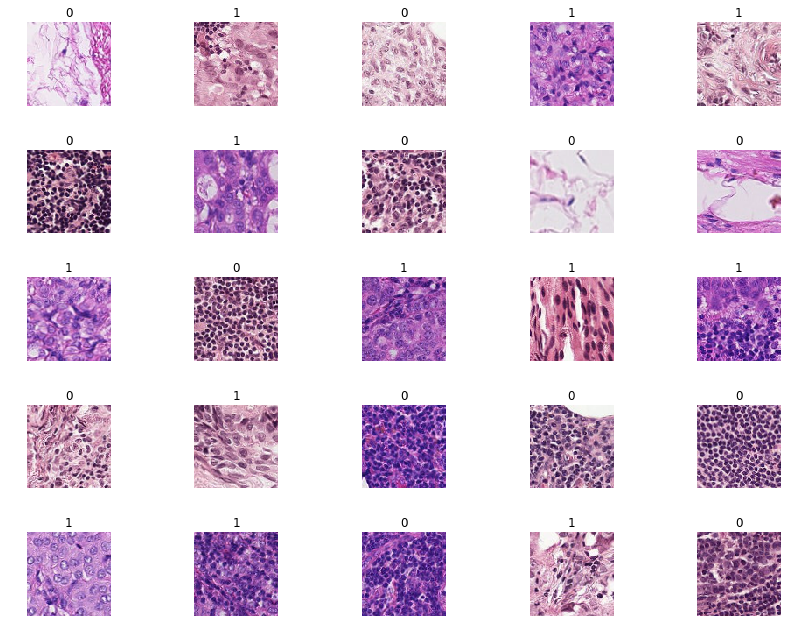

In [11]:
data.show_batch(rows=5, figsize=(12,9))

In [12]:
print(data.classes)
len(data.classes)

[0, 1]


2

# Metric

In [13]:
from sklearn.metrics import roc_auc_score

In [14]:
def auc_score(y_pred,y_true,tens=True):
    score=roc_auc_score(y_true,torch.sigmoid(y_pred)[:,1])
    if tens:
        score=tensor(score)
    else:
        score=score
    return score

In [16]:
def GenerateTestSubmission(submission_name):
    test = ImageList.from_folder(path/'test')
    export_file_name = '{}.pkl'.format(submission_name)
    learn = load_learner(path, test=test, fname=export_file_name)
    preds, _ = learn.get_preds(ds_type=DatasetType.Test)
    thresh = 0.5
    labelled_preds = [1 if pred[0] > thresh else 0 for pred in preds]
    fnames = [f.name[:-4] for f in learn.data.test_ds.items]
    df = pd.DataFrame({'id':fnames, 'label':labelled_preds}, columns=['id', 'label'])
    file_name = '{}-thresh-0.5-submission.csv'.format(submission_name)
    print(file_name)
    df.to_csv(path/file_name, index=False)

In [24]:
def GenerateTestSubmission(submission_name):
    test = ImageList.from_folder(path/'test')
    export_file_name = '{}.pkl'.format(submission_name)
    learn = load_learner(path, test=test, fname=export_file_name)
    preds, _ = learn.get_preds(ds_type=DatasetType.Test)
    thresh = 0.5
    print(preds[5:])
    print(preds[0][0])
    #print(preds[0][0][0])
    #labelled_preds = [1 if pred[0] > thresh else 0 for pred in preds]
    labelled_preds = [pred[0].item() for pred in preds]
    fnames = [f.name[:-4] for f in learn.data.test_ds.items]
    df = pd.DataFrame({'id':fnames, 'label':labelled_preds}, columns=['id', 'label'])
    file_name = '{}-thresh-none-submission.csv'.format(submission_name)
    print(file_name)
    df.to_csv(path/file_name, index=False)

In [25]:
GenerateTestSubmission('densenet169-v2-bs128-stage-2-e20-u')

tensor([[9.9999e-01, 7.5022e-06],
        [9.9099e-07, 1.0000e+00],
        [9.9996e-01, 3.9377e-05],
        ...,
        [7.2985e-09, 1.0000e+00],
        [6.7007e-01, 3.2993e-01],
        [9.9994e-01, 6.1636e-05]])
tensor(1.0000)
densenet169-v2-bs128-stage-2-e20-u-thresh-none-submission.csv


# Training: densenet169

In [15]:
gc.collect()
learn = cnn_learner(data, models.densenet169, metrics=[auc_score, accuracy], )

In [17]:
# Use the LR finder to find a good learning rate
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


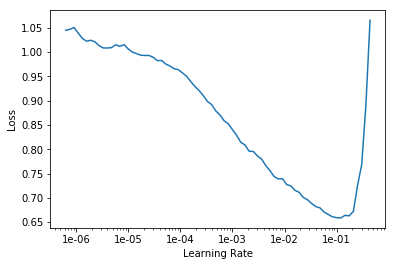

In [18]:
learn.recorder.plot()

In [19]:
lr=3e-3

In [34]:
stage_name = 'densenet169-v2-bs128-stage-1-10e-l-bm'

learn.fit_one_cycle(10,  slice(lr), callbacks=[SaveModelCallback(learn, every='epoch', monitor='auc_score', name=stage_name)])

epoch,train_loss,valid_loss,auc_score,time
0,0.286262,0.259588,0.950816,08:22
1,0.245242,0.213106,0.963164,08:21
2,0.203314,0.180620,0.974936,08:21
3,0.180165,0.159950,0.980849,08:21
4,0.163979,0.146563,0.983609,08:21
5,0.155484,0.135960,0.986799,08:22
6,0.132375,0.118846,0.989813,08:23
7,0.131182,0.115495,0.990560,08:22
8,0.123893,0.106554,0.991850,08:22
9,0.103230,0.098518,0.992889,08:21


In [35]:
stage_name = 'densenet169-v2-bs128-stage-1-10e-l'
learn.save(stage_name)
export_file_name = '{}.pkl'.format(stage_name)
learn.export(export_file_name)
GenerateTestSubmission(stage_name)

densenet169-v2-bs128-stage-1-10e-l-thresh-0.5-submission.csv


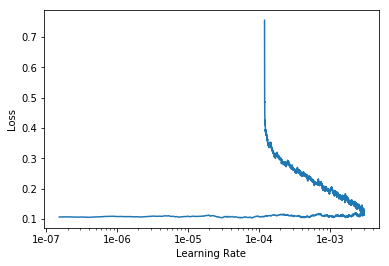

In [36]:
learn.recorder.plot()

In [37]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()
len(data.valid_ds)==len(losses)==len(idxs)

True

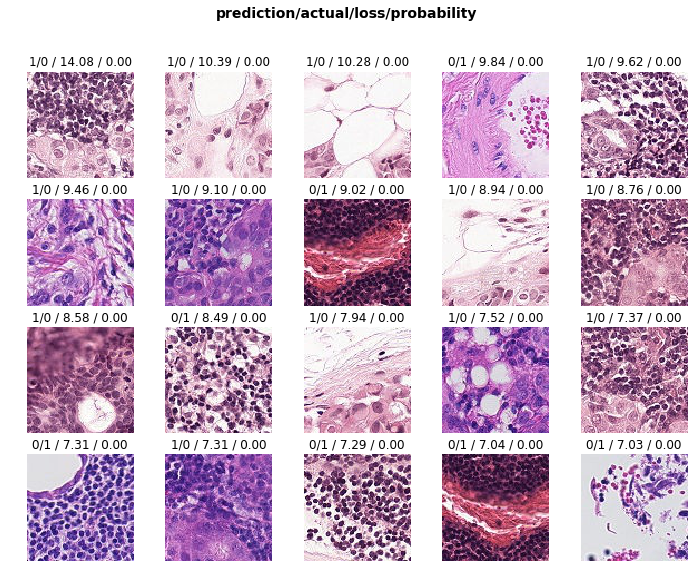

In [38]:
# data.show_batch(rows=5, figsize=(12,9))
interp.plot_top_losses(20, figsize=(12,9))

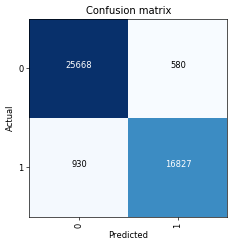

In [39]:
interp.plot_confusion_matrix(figsize=(4,4), dpi=60)

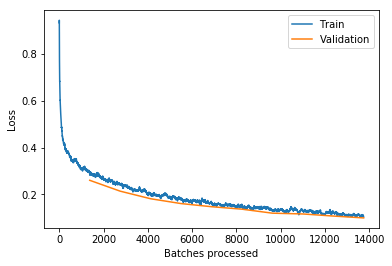

In [40]:
learn.recorder.plot_losses()

In [18]:
stage_name = 'densenet169-v2-bs128-stage-1-10e-l'
learn.load(stage_name)

Learner(data=ImageDataBunch;

Train: LabelList (176020 items)
x: ImageList
Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96)
y: CategoryList
0,1,0,0,0
Path: data/raw;

Valid: LabelList (44005 items)
x: ImageList
Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96)
y: CategoryList
0,1,0,0,0
Path: data/raw;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace)
          (conv1): Conv2d(64, 128, ke

In [18]:
lr=3e-3
learn.fit_one_cycle(10,  slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,auc_score,time
0,0.096323,0.096979,0.993114,08:30
1,0.096523,0.096135,0.993398,08:23
2,0.104245,0.095329,0.993439,08:23
3,0.101000,0.095139,0.993582,08:24
4,0.103273,0.091783,0.993757,08:24
5,0.104637,0.099706,0.993494,08:24
6,0.104685,0.096837,0.993324,08:26
7,0.096720,0.097190,0.993444,08:23
8,0.096795,0.093093,0.993715,08:23
9,0.085081,0.085823,0.994723,08:24


In [19]:
stage_name = 'densenet169-v2-bs128-stage-2-10e-l'
learn.save(stage_name)
export_file_name = '{}.pkl'.format(stage_name)
learn.export(export_file_name)
GenerateTestSubmission(stage_name)

densenet169-v2-bs128-stage-2-10e-l-thresh-0.5-submission.csv


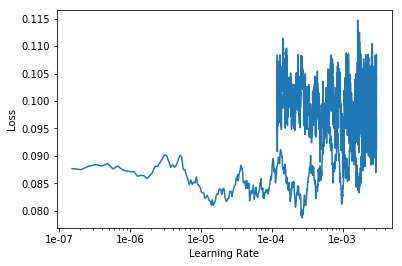

In [20]:
#learn.lr_find()
learn.recorder.plot()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


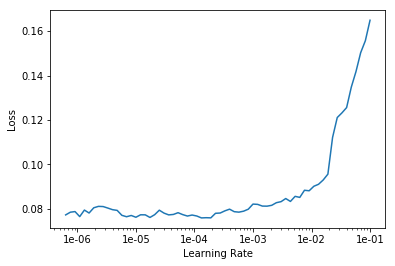

In [21]:
learn.lr_find()
learn.recorder.plot()

In [27]:
stage_name = 'densenet169-v2-bs128-stage-2-10e-l'

learn.load(stage_name)


Learner(data=ImageDataBunch;

Train: LabelList (176020 items)
x: ImageList
Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96)
y: CategoryList
0,1,0,0,0
Path: data/raw;

Valid: LabelList (44005 items)
x: ImageList
Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96)
y: CategoryList
0,1,0,0,0
Path: data/raw;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace)
          (conv1): Conv2d(64, 128, ke

# Unfreezing the model

In [24]:
lr = 1e-2
lr/3

0.0033333333333333335

In [32]:
learn.unfreeze()
lr = 1e-2
#learn.fit_one_cycle(20, slice(1e-4, 1e-2))
stage_name = 'densenet169-v3-bs128-stage-2-e20-u-bm-auc'

learn.fit_one_cycle(20, slice(lr/3, lr),  callbacks=[SaveModelCallback(learn, every='epoch', monitor='auc_score', name=stage_name)])


epoch,train_loss,valid_loss,auc_score,accuracy,time
0,0.172975,0.203322,0.977282,0.928122,10:29
1,0.184587,0.203238,0.975566,0.920305,10:25
2,0.185719,0.182470,0.978175,0.928576,10:18
3,0.179498,0.250503,0.963454,0.909533,10:20
4,0.163764,0.305972,0.972519,0.886445,10:20
5,0.168251,0.234371,0.980215,0.906511,10:15
6,0.148797,0.168340,0.987407,0.940325,10:15
7,0.141058,0.136672,0.987260,0.950460,10:18
8,0.132081,0.252452,0.981608,0.916941,10:21
9,0.132435,0.147674,0.987552,0.945915,10:21


In [33]:
stage_name = 'densenet169-v4-bs128-stage-2-e20-u'
learn.save(stage_name)
export_file_name = '{}.pkl'.format(stage_name)
learn.export(export_file_name)
GenerateTestSubmission(stage_name)

densenet169-v4-bs128-stage-2-e20-u-thresh-0.5-submission.csv


In [ ]:
tfms = get_transforms(do_flip=True, flip_vert=True, max_zoom=2, max_rotate= 45.0, \
                      max_lighting=0.9, max_warp=0.3 )


In [ ]:
sz = 96
bs = 128
data = ImageDataBunch.from_csv(path, csv_labels='train_labels.csv', \
                               folder='train', ds_tfms=tfms, size=sz, suffix='.tif',bs=bs, \
                               valid_pct=0.2)
data.normalize(imagenet_stats)
learn.data = data

In [ ]:
stage_name = 'densenet169-v4-bs128-stage-3-e20-u'
learn.fit_one_cycle(20, slice(3e-5, 1e-3),  callbacks=[SaveModelCallback(learn, every='epoch', monitor='auc_score', name=stage_name)])


In [ ]:
stage_name = 'densenet169-v4-bs128-stage-2-e20-u'
learn.save(stage_name)
export_file_name = '{}.pkl'.format(stage_name)
learn.export(export_file_name)
GenerateTestSubmission(stage_name)

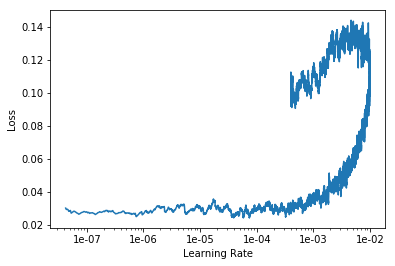

In [24]:
learn.recorder.plot()

In [25]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()
len(data.valid_ds)==len(losses)==len(idxs)

True

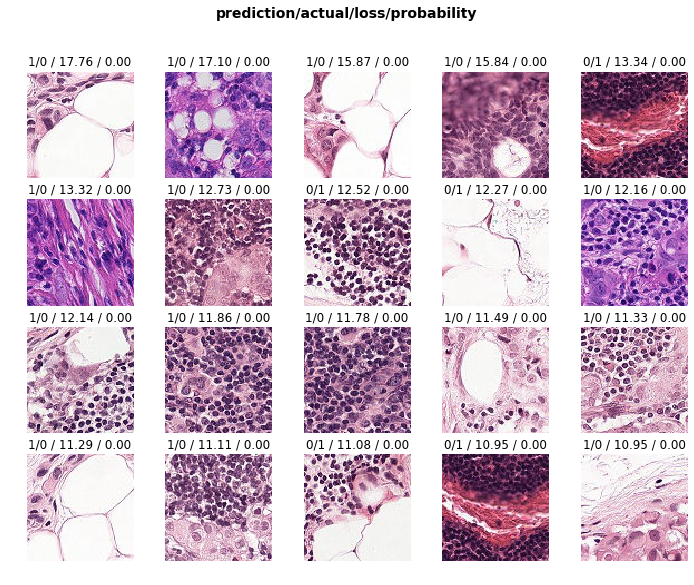

In [26]:
# data.show_batch(rows=5, figsize=(12,9))
interp.plot_top_losses(20, figsize=(12,9))

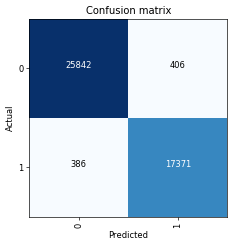

In [27]:
interp.plot_confusion_matrix(figsize=(4,4), dpi=60)

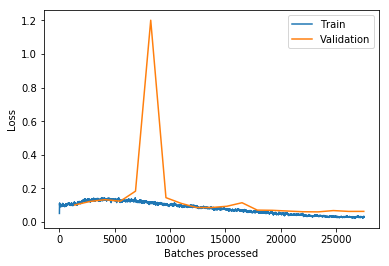

In [28]:
learn.recorder.plot_losses()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


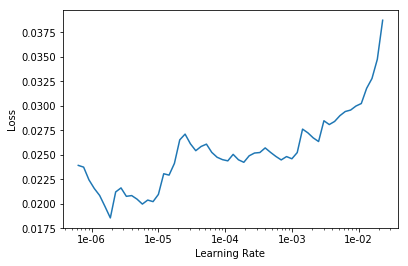

In [19]:
stage_name = 'densenet169-v2-bs128-stage-2-e20-u'
learn.load(stage_name)
learn.lr_find()
learn.recorder.plot()

In [53]:
stage_name

'densenet169-v2-bs128-stage-2-e10-u'

In [57]:
gc.collect()

0

In [22]:
learn.load(stage_name)

Learner(data=ImageDataBunch;

Train: LabelList (176020 items)
x: ImageList
Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96)
y: CategoryList
0,1,0,0,0
Path: data/raw;

Valid: LabelList (44005 items)
x: ImageList
Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96)
y: CategoryList
0,1,0,0,0
Path: data/raw;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace)
          (conv1): Conv2d(64, 128, ke

In [23]:
learn.unfreeze()
learn.fit_one_cycle(1, slice(3e-6, 1e-4))

epoch,train_loss,valid_loss,auc_score,time
0,0.023931,0.063150,0.997556,10:22


In [24]:
stage_name = 'densenet169-v2-bs128-stage-3-e1-u'
learn.save(stage_name)
export_file_name = '{}.pkl'.format(stage_name)
learn.export(export_file_name)
GenerateTestSubmission(stage_name)

densenet169-v2-bs128-stage-3-e1-u-thresh-0.5-submission.csv


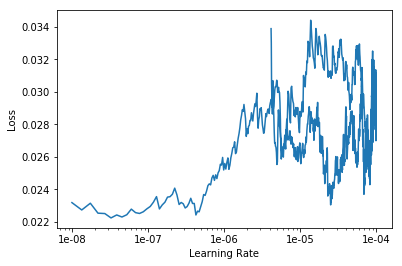

In [25]:
learn.recorder.plot()

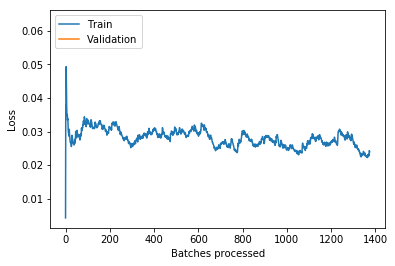

In [26]:
learn.recorder.plot_losses()

In [28]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()
len(data.valid_ds)==len(losses)==len(idxs)

True

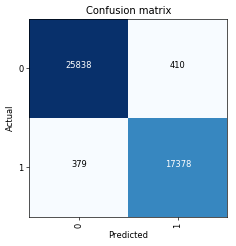

In [29]:
interp.plot_confusion_matrix(figsize=(4,4), dpi=60)

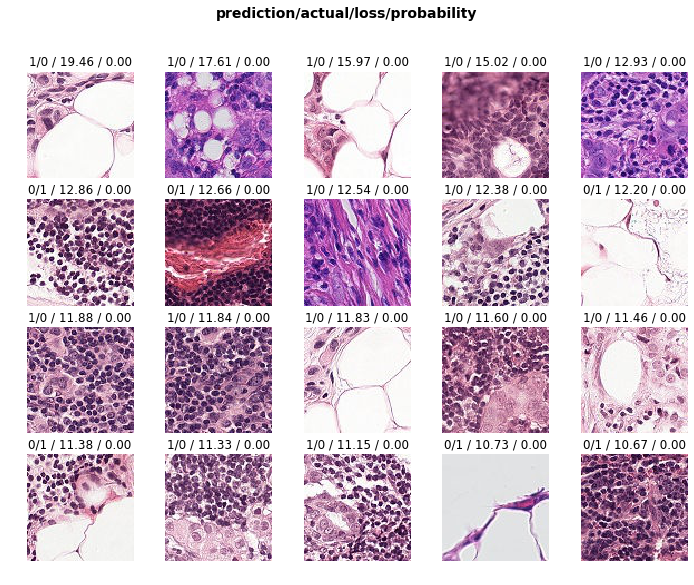

In [30]:
interp.plot_top_losses(20, figsize=(12,9))

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


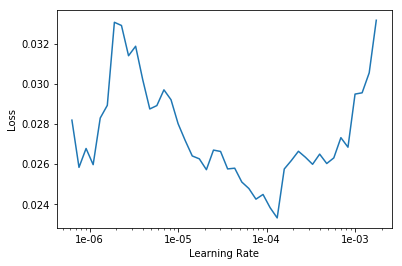

In [31]:
learn.load(stage_name)
learn.lr_find()
learn.recorder.plot()

In [32]:
learn.unfreeze()
learn.fit_one_cycle(10, slice(3e-4, 3e-3))

epoch,train_loss,valid_loss,auc_score,time
0,0.042441,0.064821,0.997104,10:18
1,0.074644,0.098905,0.992984,10:18
2,0.089058,0.093500,0.993999,10:18
3,0.081513,0.093216,0.994451,10:19
4,0.080035,0.110663,0.994101,10:19
5,0.060500,0.077999,0.996046,10:19
6,0.045394,0.065890,0.996981,10:19
7,0.041107,0.058913,0.997478,10:20
8,0.025541,0.059696,0.997777,10:19
9,0.024183,0.060209,0.997825,10:18


In [33]:
stage_name = 'densenet169-v2-bs128-stage-3-e10-u'
learn.save(stage_name)
export_file_name = '{}.pkl'.format(stage_name)
learn.export(export_file_name)
GenerateTestSubmission(stage_name)

densenet169-v2-bs128-stage-3-e10-u-thresh-0.5-submission.csv


In [34]:
learn.unfreeze()
learn.fit_one_cycle(10, slice(3e-6, 1e-5))

epoch,train_loss,valid_loss,auc_score,time
0,0.023779,0.059854,0.997843,10:17
1,0.028459,0.058753,0.997838,10:17
2,0.023862,0.058730,0.997891,10:17
3,0.023933,0.058875,0.997890,10:18
4,0.023797,0.059058,0.997899,10:18
5,0.022194,0.060549,0.997820,10:19
6,0.024072,0.060916,0.997822,10:19
7,0.025196,0.060390,0.997883,10:20
8,0.023055,0.060009,0.997843,10:19
9,0.023591,0.059523,0.997887,10:19


In [35]:
stage_name = 'densenet169-v2-bs128-stage-3-e20-u'
learn.save(stage_name)
export_file_name = '{}.pkl'.format(stage_name)
learn.export(export_file_name)
GenerateTestSubmission(stage_name)

densenet169-v2-bs128-stage-3-e20-u-thresh-0.5-submission.csv


In [55]:
learn.lr_find()
learn.recorder.plot()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


RuntimeError: CUDA out of memory. Tried to allocate 45.00 MiB (GPU 0; 5.93 GiB total capacity; 4.50 GiB already allocated; 50.88 MiB free; 73.66 MiB cached)

## Training Unfreezed Model for another 10 cycles with adjusted learning rate

In [59]:
stage_name = 'densenet169-v2-bs128-stage-1-10e-l'

learn.load(stage_name)

Learner(data=ImageDataBunch;

Train: LabelList (176020 items)
x: ImageList
Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96)
y: CategoryList
0,1,0,0,0
Path: data/raw;

Valid: LabelList (44005 items)
x: ImageList
Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96)
y: CategoryList
0,1,0,0,0
Path: data/raw;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace)
          (conv1): Conv2d(64, 128, ke

In [ ]:

learn.unfreeze()
learn.fit_one_cycle(20, slice(1e-6, 1e-2))

In [ ]:
stage_name = 'densenet169-v2-bs128-stage-3-e20-u'
learn.save(stage_name)
export_file_name = '{}.pkl'.format(stage_name)
learn.export(export_file_name)
GenerateTestSubmission(stage_name)

In [42]:
stage_name = 'densenet169-bs128-stage-2-e10-u'
learn.load(stage_name)

Learner(data=ImageDataBunch;

Train: LabelList (176020 items)
x: ImageList
Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96)
y: CategoryList
0,1,0,0,0
Path: data/raw;

Valid: LabelList (44005 items)
x: ImageList
Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96)
y: CategoryList
0,1,0,0,0
Path: data/raw;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace)
          (conv1): Conv2d(64, 128, ke

In [45]:
epoch = 10
for i in range(1,11):
    learn.unfreeze()
    learn.fit_one_cycle(1,  slice(1e-5, 1e-3))
    new_epoch = epoch + i
    stage_name = 'densenet169-bs128-stage-1-e{}-u'.format(new_epoch)
    learn.save(stage_name)


epoch,train_loss,valid_loss,auc_score,time
0,0.047287,0.069715,0.996653,10:20


epoch,train_loss,valid_loss,auc_score,time
0,0.042101,0.069380,0.996674,10:20


epoch,train_loss,valid_loss,auc_score,time
0,0.040931,0.069039,0.996808,10:20


epoch,train_loss,valid_loss,auc_score,time
0,0.043422,0.068157,0.996944,10:25


epoch,train_loss,valid_loss,auc_score,time
0,0.040804,0.069938,0.996985,10:20


epoch,train_loss,valid_loss,auc_score,time
0,0.039768,0.069309,0.996906,10:20


epoch,train_loss,valid_loss,auc_score,time
0,0.037090,0.070205,0.996949,10:20


epoch,train_loss,valid_loss,auc_score,time
0,0.036412,0.071185,0.996868,10:19


epoch,train_loss,valid_loss,auc_score,time
0,0.035829,0.070118,0.996922,10:19


epoch,train_loss,valid_loss,auc_score,time
0,0.033985,0.072683,0.996997,10:19


In [46]:
stage_name = 'densenet169-bs128-stage-2-e20-u'
learn.load(stage_name)
export_file_name = '{}.pkl'.format(stage_name)
learn.export(export_file_name)
GenerateTestSubmission(stage_name)

densenet169-bs128-stage-1-e20-u-thresh-0.5-submission.csv


In [48]:
stage_name = 'densenet169-bs128-stage-2-e10-u'
learn.load(stage_name)

Learner(data=ImageDataBunch;

Train: LabelList (176020 items)
x: ImageList
Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96)
y: CategoryList
0,1,0,0,0
Path: data/raw;

Valid: LabelList (44005 items)
x: ImageList
Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96)
y: CategoryList
0,1,0,0,0
Path: data/raw;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace)
          (conv1): Conv2d(64, 128, ke

In [49]:
learn.unfreeze()
learn.fit_one_cycle(20,  slice(1e-5, 1e-3))


densenet169-bs128-stage-2-e20-u-thresh-0.5-submission.csv


In [ ]:

stage_name = 'densenet169-bs128-stage-2-e20-u'
learn.save(stage_name)
export_file_name = '{}.pkl'.format(stage_name)
learn.export(export_file_name)
GenerateTestSubmission(stage_name)

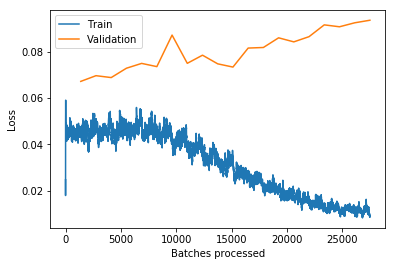

In [50]:
learn.recorder.plot_losses()

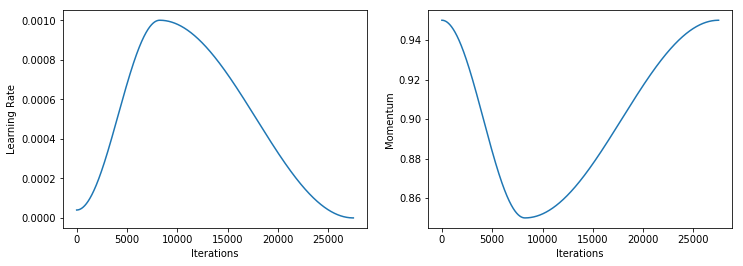

In [51]:
learn.recorder.plot_lr(show_moms=True)